<a href="https://www.kaggle.com/code/mahyararani/fraudclassification?scriptVersionId=112071255" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#241571; background:#B5cae9; border:2px dashed #efe50b;" role="tab" aria-controls="goal"><center></bold>Fraud Classification: An Explotation of Classification Models</center></h1>

![Linear_Regression.jpg](https://www.frbservices.org/binaries/content/gallery/crsocms/news/fed360/070120/fraudclassifier-full.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer # Imputing missing values
from imblearn.under_sampling import RandomUnderSampler # Class Imbalance

# Numerical features selection
from sklearn.decomposition import PCA 

# Categorical Features Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Model validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Model Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Other General Imports
import gc
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

# Data Loading and Reducing the Size

Since the data is big in size, we will use function to reduce its memory for fast processing and consuming less storage.

In [2]:
start = time.time()
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
tt = pd.read_csv('../input/ieeecis-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('../input/ieeecis-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()

del tt, ti

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%
Train shape (590540, 434)


In [4]:
# loading test_transaction data
ts = pd.read_csv('../input/ieeecis-fraud-detection/test_transaction.csv')
print(ts.shape)
ts = reduce_mem_usage(ts)

tsi = pd.read_csv('../input/ieeecis-fraud-detection/test_identity.csv')
print(tsi.shape)
tsi = reduce_mem_usage(tsi)

test = pd.merge(ts, tsi, how = 'left')
print('Test shape',test.shape)
test.head()

del ts, tsi

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%
Test shape (506691, 433)


# Data Understanding

## Data Exploration

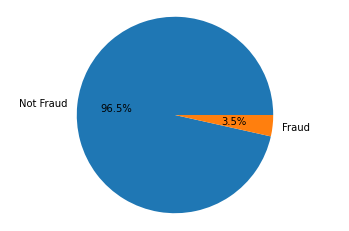

In [5]:
# Class imbalance check
plt.pie(train.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

As one can expect, this is a class imbalance problem. Thus, the accuracy and specifity are not a good criteria to measure the models we want to apply later and we must change the sensitivity in our classification models and change it to 0.35 indstead of 0.5 or apply more novel methods dealing with imbalance dataset. 
We will apply UnderSampling to deal with class imbalance in later steps. Let us understand the distribution of the timestamp column.

### TransactionDT

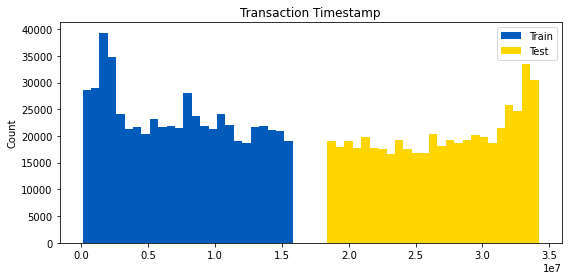

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(train['TransactionDT'], label='Train', bins = 25, color="#005BBB")
plt.hist(test['TransactionDT'], label='Test', bins = 25, color= "#FFD500")
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

The difference train.min() and test.max() is x = 34214345 - 86400 = 34127945 but we don't know is it in seconds,minutes or hours.

If it is in hours then the dataset timespan will be x/(24*365) = 3895.884132 years which is not possible.

if it is in minutes then the dataset timespan will be x/(60*24*365) = 64.931402 years which is not possible because Vesta Corporation was founded in 1995 so they can have at most 24 years of data.

If it is in seconds then dataset timespan will be x/(3600*24*365) = 1.0821 years which seems reasonable to me.

**Time span of the total dataset is 394.9993634259259 days**

**Time span of Train dataset is  181.99920138888888 days**

**Time span of Test dataset is  182.99908564814814 days**

**The gap between train and test is 30.00107638888889 days**

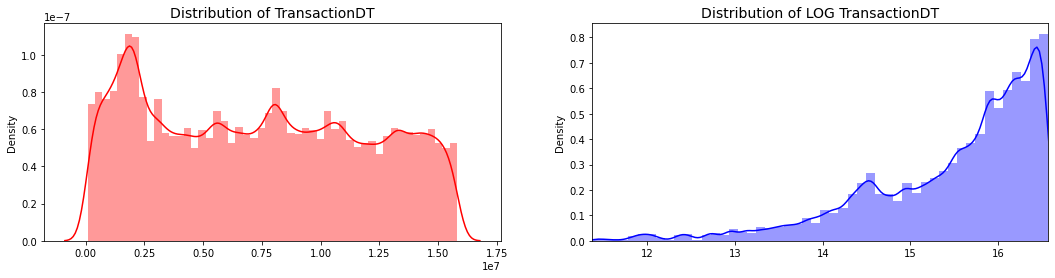

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

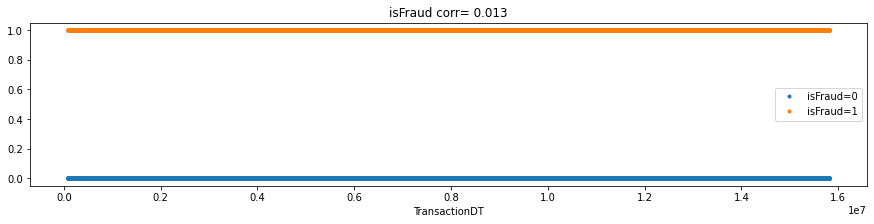

In [8]:
i = 'isFraud'
cor = np.corrcoef(train['TransactionDT'], train[i])[0,1]
train.loc[train['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train.loc[train['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

### Transation Amount

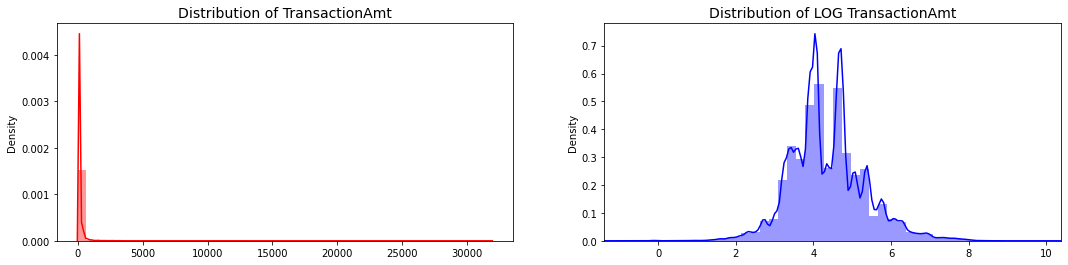

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

### ProductCD Feature

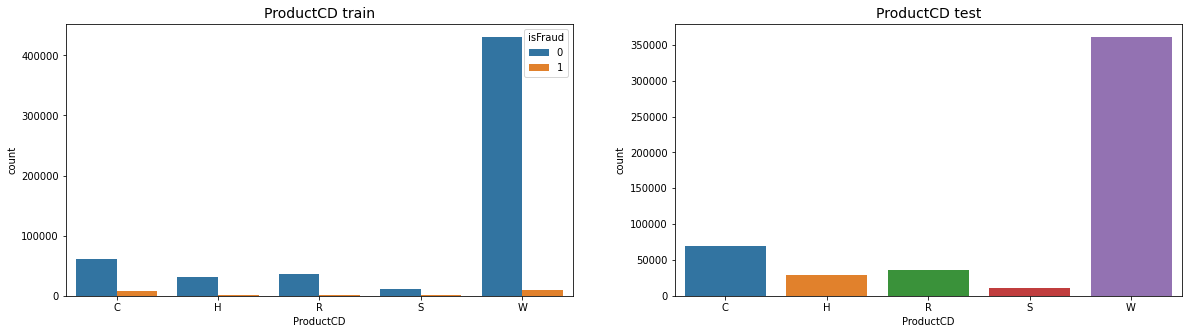

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

### Cards Features

Text(0, 0.5, 'Transaction Values')

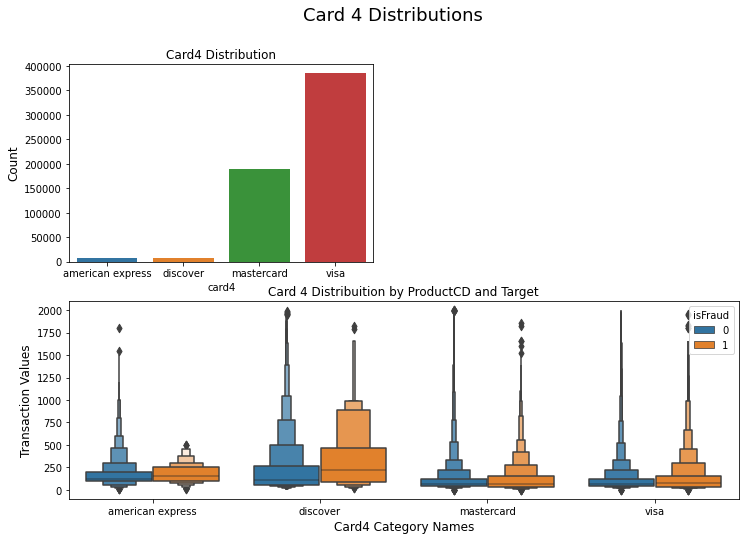

In [11]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 4 Distributions', fontsize=18)

plt.subplot(221)
g1 = sns.countplot(x='card4', data=train)
g1 = sns.countplot(x='card4', data=train)
g1.set_title("Card4 Distribution", fontsize=12)
g1.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g2 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g2.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=12)
g2.set_xlabel("Card4 Category Names", fontsize=12)
g2.set_ylabel("Transaction Values", fontsize=12)


Text(0, 0.5, 'Transaction Values')

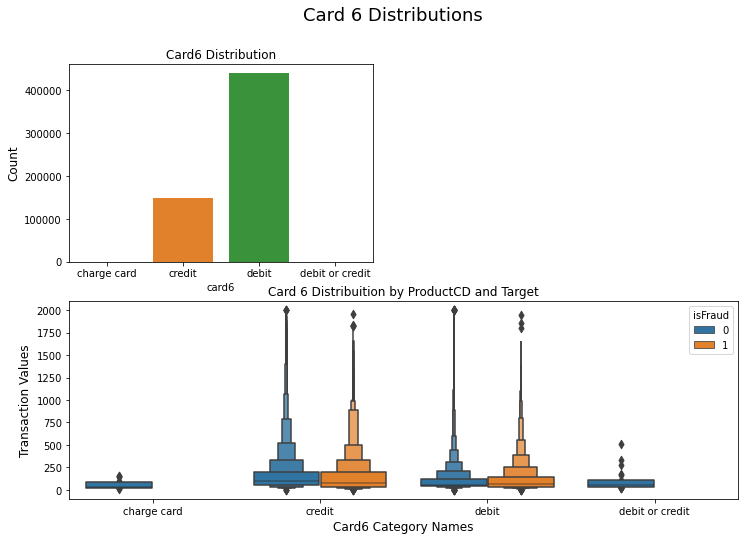

In [12]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 6 Distributions', fontsize=18)

plt.subplot(221)
g = sns.countplot(x='card6', data=train)
g.set_title("Card6 Distribution", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g1.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=12)
g1.set_xlabel("Card6 Category Names", fontsize=12)
g1.set_ylabel("Transaction Values", fontsize=12)


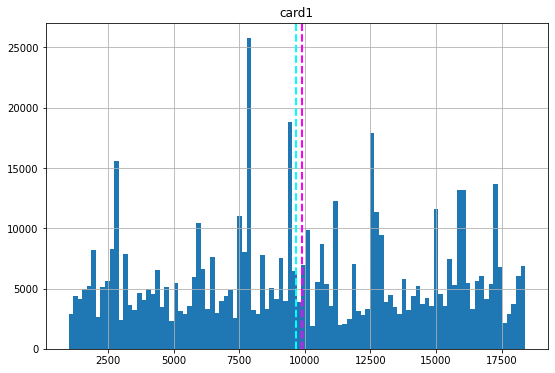

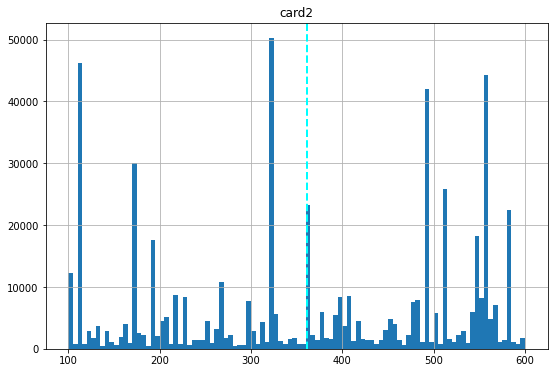

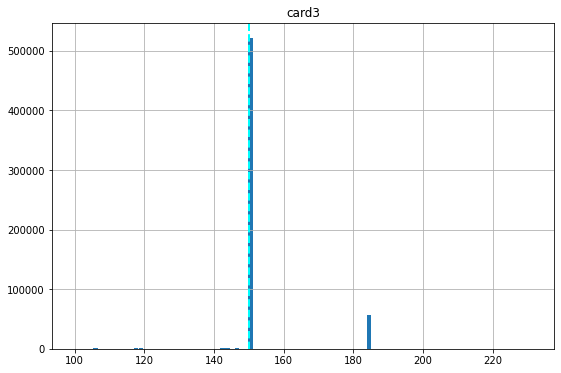

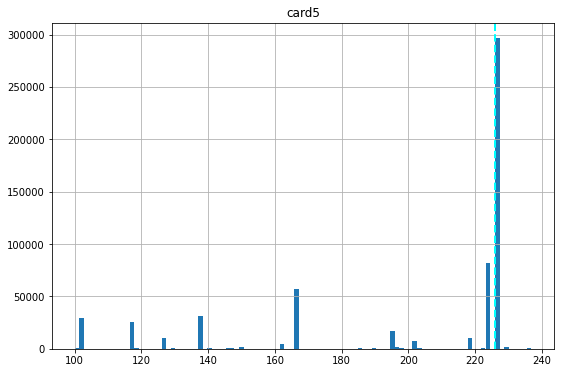

In [13]:
cards = ['card1', 'card2', 'card3', 'card5']

for col in cards:
    fig = plt.figure(figsize = (9,6))
    ax = fig.gca()
    feature = train[col]
    feature.hist(bins = 100, ax=ax)
    ax.axvline(feature.mean(), color = 'magenta', linestyle = 'dashed', linewidth = 2)
    ax.axvline(feature.median(), color= 'cyan', linestyle = 'dashed', linewidth = 2)
    ax.set_title(col)
plt.show()

### Addr1 and Addr2 Features

In [14]:
print("Card Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, 0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975, 0.99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


### C1-C14 Features

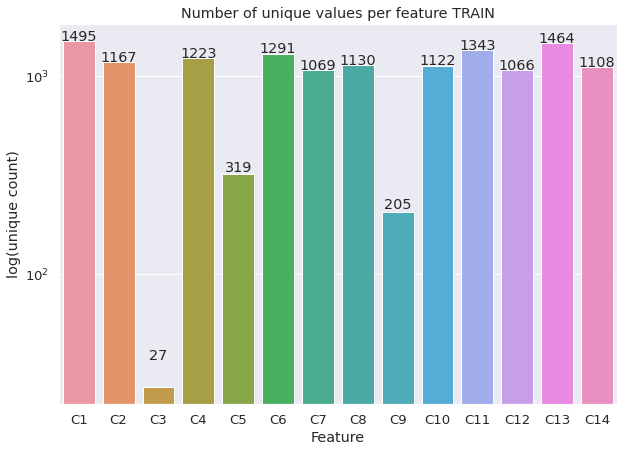

In [25]:
plt.figure(figsize=(10, 7))
c_features = list(train.columns[17:31])
uniques = [len(train[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### D1-D15 Features

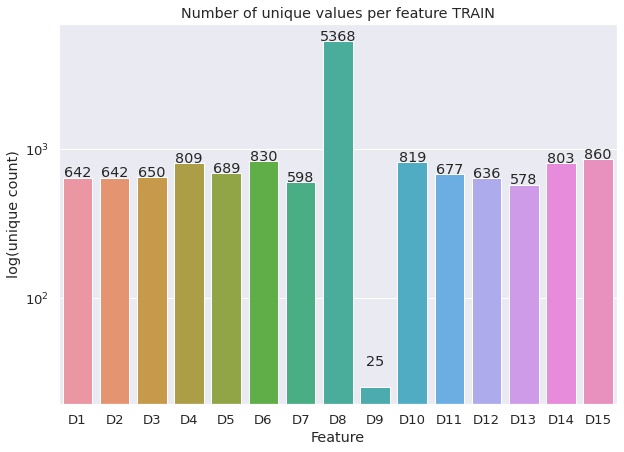

In [28]:
plt.figure(figsize=(10, 7))
d_features = list(train.columns[31:46])
uniques = [len(train[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### V1-V339 Features

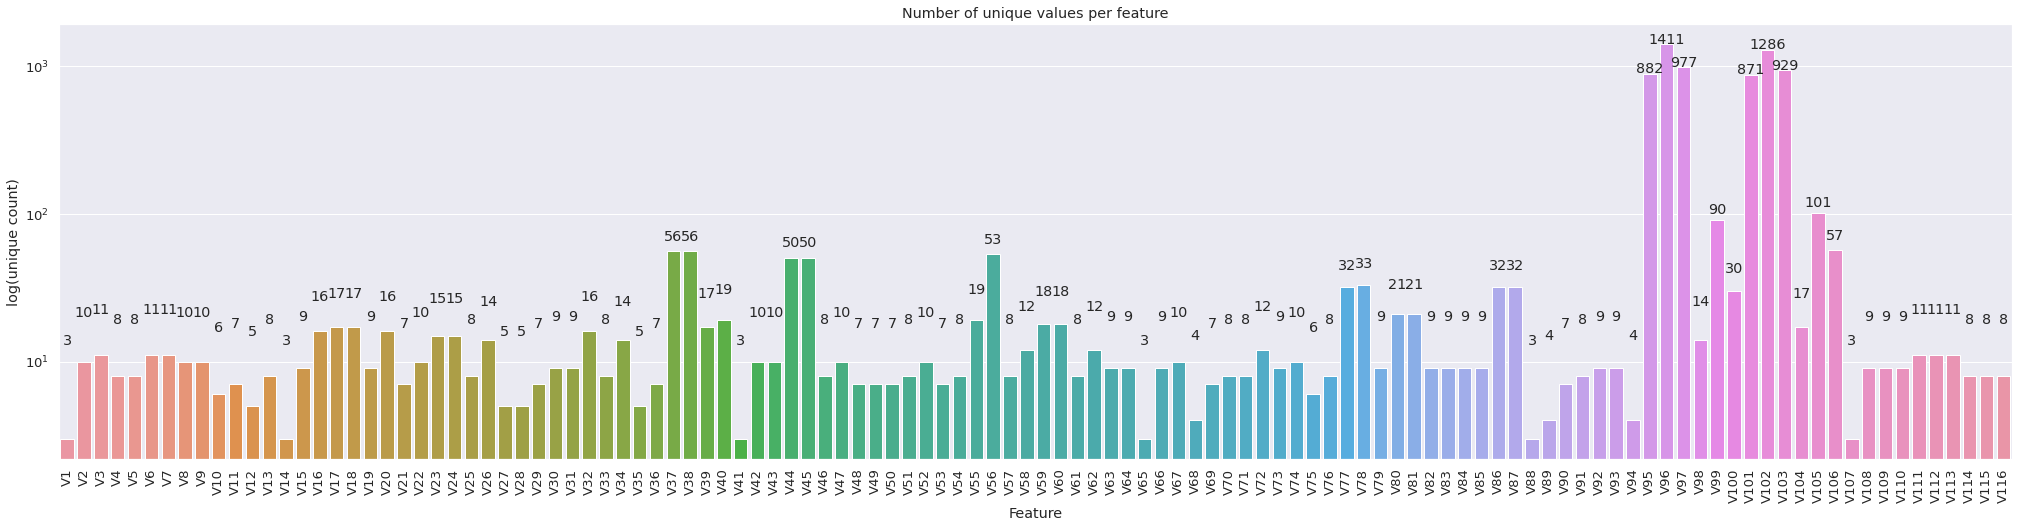

In [32]:
plt.figure(figsize=(35, 8))
v_features = list(train.columns[55:171])
uniques = [len(train[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
ax.set_xticklabels(v_features, rotation = 90)
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Device Type in Train Identity

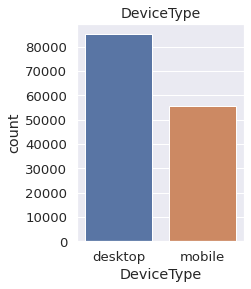

In [33]:
ax = sns.countplot(x="DeviceType", data=train)
ax.set_title('DeviceType', fontsize=14)
sns.set(rc={"figure.figsize": (3,4)})
plt.show()

### Device Information in Train Identity

In [34]:
print ("Unique Devices = ",train['DeviceInfo'].nunique())
train['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

# Data Preparation

In [35]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [36]:
summary(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,590540
1,isFraud,int8,0,2
2,TransactionDT,int32,0,573349
3,TransactionAmt,float16,0,8195
4,ProductCD,category,0,5
...,...,...,...,...
429,id_36,category,449555,2
430,id_37,category,449555,2
431,id_38,category,449555,2
432,DeviceType,category,449730,2


In [37]:
summary(test)

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,506691
1,TransactionDT,int32,0,494686
2,TransactionAmt,float16,0,7343
3,ProductCD,category,0,5
4,card1,int16,0,13244
...,...,...,...,...
428,id-36,category,369714,2
429,id-37,category,369714,2
430,id-38,category,369714,2
431,DeviceType,category,369760,2


## Feature Transformation
### Handling and Genearating Features

In [38]:
def Devices(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df = df.drop(['DeviceInfo'], axis = 1)
    
    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]
    df = df.drop(['id_30'], axis = 1)
    
    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(' ', expand=True)[1]
    df = df.drop(['id_31'], axis = 1)

    df['screen_width'] = df['id_33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x', expand=True)[1]
    df = df.drop(['id_33'], axis = 1)

    df['id_34'] = df['id_34'].str.split(':', expand=True)[1]
    df['id_23'] = df['id_23'].str.split(':', expand=True)[1]
    df = df.drop(['id_34', 'id_23'], axis = 1)


    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

In [39]:
train = Devices(train)

## Dealing with Missing Data

### Identifying the uniqueness of categorical features

In [40]:
train.drop_duplicates(inplace = True)

We are going to drop the columns with more than 80% missing values baed on [THIS](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8) paper.

Let us now fill all the missing values. For numerical columns, we will use median value and for categorical column, we will use the most frequent category to fill the missing values.

In [41]:
y = train['isFraud']
TransactionID = train['TransactionID']
TransactionDT = train['TransactionDT']
gc.collect()

23

In [42]:
del test

In [43]:
# Dropping columns with more than 80% missing values 
print("Shape before dropping features more than 20% missing values: ", train.shape)
mv = train.isnull().sum()/len(train)
train = train.drop(columns=mv[mv>0.8].index)

print("Shape after dropping features more than 20% missing values: ", train.shape)

Shape before dropping features more than 20% missing values:  (590540, 437)
Shape after dropping features more than 20% missing values:  (590540, 362)


In [44]:
train.dropna(how= 'all', axis = 0)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_29,id_35,id_36,id_37,id_38,DeviceType,device_name,browser_id_31,version_id_31,had_id
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,NotFound,T,F,T,T,mobile,Samsung,samsung,browser,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Based on metadata Categorical Featurs are:

* ProductCD
* emaildomain
* card4 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9
* DeviceType
* DeviceInfo
* id_12 - id_38

However, by filtering the features based on the data type (obj) we have more categorical features.

In [45]:
train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
# Filtering numerical data
num_df = train.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df = train.select_dtypes(exclude=np.number)
print(cat_df.shape)

(590540, 332)
(590540, 27)


In [46]:
num_df.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,had_id
0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,1.0,...,0.0,70787.0,NaN,NaN,100.0,NaN,166.0,542.0,144.0,1


In [47]:
cat_df.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType,device_name,browser_id_31,version_id_31
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,New,NotFound,T,F,T,T,mobile,Samsung,samsung,browser


In [48]:
del train
gc.collect()

23

In [49]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_median = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_median.fit_transform(cat_df), columns=cat_df.columns)

    
cat_df.isnull().sum()
num_df.isnull().sum()

(590540, 332)


TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
                 ..
id_13             0
id_17             0
id_19             0
id_20             0
had_id            0
Length: 332, dtype: int64

## Numerical Features

In [50]:
scaled_num = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
scaled_num.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,had_id
0,0.002137,0.743044,0.522,0.381679,0.306569,0.488636,0.836957,0.001847,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
1,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,0.000778,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
2,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027897,0.000213,0.000176,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
3,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,0.000778,0.000427,0.000878,...,0.95,0.125851,0.580645,1.0,1.0,0.777778,0.511628,0.422067,0.663102,0.0
4,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,0.000778,0.000213,0.000176,...,1.00,0.070815,0.580645,1.0,1.0,0.777778,0.511628,0.774081,0.078431,0.0


### PCA for Numerical Features

Text(0, 0.5, 'Cumulative Rate of Variance')

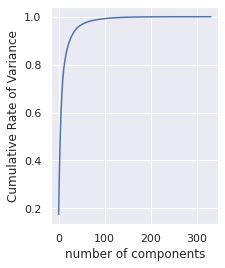

In [51]:
pca = PCA().fit(scaled_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative Rate of Variance")

In [52]:
#final
pca = PCA(n_components = 0.95)

pca_fit = pca.fit_transform(scaled_num)
num_pca = pd.DataFrame(data = pca_fit)
pca.explained_variance_ratio_.sum()
del num_df, scaled_num

In [53]:
num_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.323767,-0.195413,0.165047,0.427136,0.045425,-0.186387,0.063809,-0.061365,-0.064428,-0.080384,...,-0.007998,-0.025171,-0.016574,0.035473,-0.006006,-0.010612,0.004359,-0.001721,-0.073779,-0.003276
1,-0.366990,0.269999,0.131883,0.182788,0.673383,-0.025724,0.096363,0.213207,-0.049690,-0.418528,...,-0.004724,0.011852,0.012607,-0.018629,-0.003677,0.002857,0.008616,0.004802,-0.007791,-0.016422
2,-0.076643,-0.157790,-0.199622,0.119463,0.420860,-0.200106,0.106679,0.097227,-0.202645,0.195683,...,-0.023139,0.002008,0.025556,0.017241,-0.008901,0.000854,0.015355,0.002122,-0.009984,-0.002584
3,-0.204429,-0.035661,-0.128648,0.859522,-0.011436,-0.228297,0.410293,-0.023283,-0.090311,-0.063734,...,-0.014402,-0.015144,0.001526,-0.001284,-0.022878,0.149148,0.004521,-0.048259,0.074443,-0.009957
4,-0.391432,-0.134168,-0.106163,0.423674,0.660365,-0.249032,0.361606,-0.002510,-0.107527,-0.072404,...,0.023231,0.019881,-0.017445,-0.024127,0.013637,0.000573,0.021267,-0.004428,-0.004140,-0.021780


## Categorical Features

Due to we have too many values in some categories, we try to map them into new categories.

In [54]:
for x in cat_df.columns:
    #printing unique values
    print(x ,':', len(cat_df[x].unique()))

ProductCD : 5
card4 : 4
card6 : 4
P_emaildomain : 59
R_emaildomain : 60
M1 : 2
M2 : 2
M3 : 2
M4 : 3
M5 : 2
M6 : 2
M7 : 2
M8 : 2
M9 : 2
id_12 : 2
id_15 : 3
id_16 : 2
id_28 : 2
id_29 : 2
id_35 : 2
id_36 : 2
id_37 : 2
id_38 : 2
DeviceType : 2
device_name : 13
browser_id_31 : 39
version_id_31 : 40


In [55]:
cat_df = pd.get_dummies(cat_df)
cat_df.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,version_id_31_67.0,version_id_31_69.0,version_id_31_7.0,version_id_31_9.0,version_id_31_browser,version_id_31_generic,version_id_31_mobile,version_id_31_safari,version_id_31_search,version_id_31_webview
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


# Tree-based Categorical Feature Selection

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, criterion = 'entropy')
clf = clf.fit(cat_df, y)

In [ ]:
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
cat_new.head()

### Concatenating Numerical and Categorical Features 

In [ ]:
# Concatinating numerical and categorical data
df = pd.concat([y, TransactionID, TransactionDT, num_pca, cat_new], axis=1)
df = pd.DataFrame(df)

# Verifying missing values
print(f'Total missing values: {df.isnull().sum().sum()}')
print(df.shape)
df.head()

In [ ]:
del  cat_new, num_pca, y
gc.collect()

In [ ]:
df = reduce_mem_usage(df)

**This part is only for reducing time work on the clean dataset and apply the models**

In [ ]:
df.to_csv('df.csv')

In [ ]:
df = pd.read_csv('../input/dffraudclassification/df.csv')
df.head()

In [ ]:
df = reduce_mem_usage(df)

### Class Imbalance

We applied udersampling to decrease the modeling time and better identifieying the isFraud target feature.

In [ ]:
y = df['isFraud']
X = df.drop(['isFraud', 'Unnamed: 0', 'TransactionID', 'TransactionDT'], axis = 1)
X_array=np.array(X)

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

pd.value_counts(y_resampled)

In [ ]:
X_df = pd.DataFrame(X_resampled, columns = X.columns)
y_df = pd.DataFrame(y_resampled)
df = pd.concat([X_df, y_df], axis= 1)
df.shape 
df.head()

In [ ]:
# Class imbalance check
plt.pie(y_df.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
df.shape 

In [ ]:
del X_df, y_df, X_resampled, y_resampled
gc.collect()

# Modeling

In [ ]:
y = df['isFraud']
X = df.drop(['isFraud'], axis = 1)

## Naive Bayes

In [ ]:
nb_clf = naive_bayes.BernoulliNB()

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

With GuassianNB the scores are relatively lower.

In [ ]:
y_scores = nb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
NBScore = metrics.auc(fpr, tpr)
print(NBScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bernoulli Naive Bayes')
plt.show()

In [ ]:
metrics.plot_confusion_matrix(nb_clf, X_test, y_test).ax_.grid(False)

## Logistic Regression

In [ ]:

lg_clf = LogisticRegression(solver="liblinear")

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lg_clf.fit(X_train, y_train)
    y_pred = lg_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = lg_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
LGScore = metrics.auc(fpr, tpr)
print(LGScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

## KNN Classifier
### Tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(metrics.precision_score(y_test, pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,10), error_rate,color='g', linestyle='dashed', marker='o', markerfacecolor='b', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=8, weights='distance')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = knn_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
KNScore = metrics.auc(fpr, tpr)
print(KNScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- K-Nearest neighbors')
plt.show()

## Support Vector Machine (SVM)

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average="weighted")
rec = metrics.recall_score(y_test, y_pred, average="weighted")
f1 = metrics.f1_score(y_test, y_pred, average="weighted")

print("acc: {:.4f}\nprec: {:.4f}\nrec: {:.4f}\nf1: {:.4f}".format(acc, prec, rec, f1))

In [ ]:
# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
SVScore= metrics.auc(fpr, tpr)
print(SVScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Support Vector Machine')
plt.show()

In [ ]:
gc.collect()

## Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = dt_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
DTScore = metrics.auc(fpr, tpr)
print(DTScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Decision Tree')
plt.show()

## Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(criterion = 'entropy')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = rf_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

## MLP Classifier

### Tuning

In [ ]:
parameter_space = {
    'max_iter': [500, 1000, 2000],
    'hidden_layer_sizes': [(10, ), (20,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.1, 0.5, 0.9],
}
MLP_clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=2)
MLP_clf.fit(X, y)

In [ ]:
print('Best parameters found:\n', MLP_clf.best_params_)

In [ ]:
kfold = KFold(n_splits =4, shuffle=True, random_state=0)

acc, prec, rec, f1 = [], [], [], []

for train_idx, test_idx in kfold.split(df):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_scaler = preprocessing.MinMaxScaler()
    X_train = X_scaler.fit_transform(X_train)
    
    mlp_clf = MLPClassifier(hidden_layer_sizes=(10,),
                            max_iter=500,
                            activation="relu",
                            alpha= 0.5)
        
    
    mlp_clf.fit(X_train, y_train)
    
    y_pred = mlp_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average= 'weighted')]
    prec += [metrics.precision_score(y_pred, y_test, average= 'weighted')]
    f1 += [metrics.f1_score(y_pred, y_test, average= 'weighted')]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall    = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = mlp_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
MLPScore = metrics.auc(fpr, tpr)
print(MLPScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

## Bagging Classifier

In [ ]:
bc_clf = BaggingClassifier()

kf = KFold(n_splits = 4, shuffle = True, random_state =0)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    bc_clf.fit(X_train, y_train)
    y_pred = bc_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = bc_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
BCScore = metrics.auc(fpr, tpr)
print(BCScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bagging Classifier')
plt.show()

In [ ]:
metrics.plot_confusion_matrix(bc_clf, X_test, y_test).ax_.grid(False)

## Gradient Boosting Classifier
### Tuning

In [ ]:
#gb_clf = GradientBoostingClassifier(learning_rate=0.001, max_depth= 8,
#                                    max_features=5, n_estimators= 100, random_state=0)
gb_clf = GradientBoostingClassifier()
kf = KFold(n_splits = 4, shuffle = True)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

In [ ]:
y_scores = gb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
GBScore = metrics.auc(fpr, tpr)
print(GBScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Gradient Boosting')
plt.show()

# Comparing Models

In [ ]:
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.plot(['N_Bayes', 'Logistic_R', 'KNN', 'SVM', 'D_Tree', 'R_Forest', 'MLP', 'Bagging', 'G_Boost'],
         [NBScore, LGScore, KNScore, SVScore, DTScore, RFScore, MLPScore, BCScore, GBScore], 'ro', markersize=10)

plt.show()

**We could see Rando Forest Classifier has the higherst average score, now we continue to tune and make it as a pipeline after hyperparameter tuning.**

In [ ]:
print('Time Spent:', time.time() - start)

In [ ]:
gc.collect()

## Chosen Model HyperParameters Tuning

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**We are going to perform hypertuning parameter by GridSearchCV in narrow ranges, especially focusing in finding the string parameters and then use Randomized GridSearchCV to expand the ranges to find best parameters over in large number of especially max_ddepth and n_estimators**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

space = {
    "bootstrap": hp.choice("bootstrap", [True, False]),
    "n_estimators": hp.choice("n_estimators", [400, 500, 600, 800]),
    "max_depth": hp.choice("max_depth", [50, 100, 200]),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "max_features": hp.choice("max_features", ['sqrt', 'auto']),
    "min_samples_leaf": hp.choice ("min_samples_leaf", [1, 3, 5]),
    "min_samples_split": hp.choice("min_samples_split", [2, 3, 4])
    
}

def hyperparameter_tuning(params):
    rf = RandomForestClassifier(**params,n_jobs=-1, verbose = 0)
    rf.fit(X_train, y_train)
    y_scores = rf.predict_proba(X_test)
    roc= metrics.roc_auc_score(y_test, y_scores[:,1])
    return {"loss": -roc, "status": STATUS_OK}


trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=5, 
    trials=trials
)

print("Best: {}".format(best))

In [ ]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rf = RandomForestClassifier()
param_grid = {'bootstrap': [True, False],
              'criterion': ['entropy', 'gini'],
              'max_depth': [50, 100, 150],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 3, 5],
              'min_samples_split': [2, 4],
              'n_estimators': [100, 200]
             }

RF_clf = GridSearchCV(estimator = rf,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv= 2,
                      verbose=1,
                      n_jobs = -1)

RF_clf.fit(X_train, y_train)
print('Best parameters found:\n', RF_clf.best_params_)

print('Time Spent:', time.time() - start)

In [ ]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rf = RandomForestClassifier()
param_grid = {'bootstrap': [False],
              'criterion': ['entropy'],
              'max_depth': range(100, 300, 50),
              'max_features': ['auto'],
              'min_samples_leaf': [1, 3],
              'min_samples_split': range(1, 11, 2),
              'n_estimators': range(200, 1000, 50)
             }

RF_clf = RandomizedSearchCV(estimator = rf,
                            n_iter = 30,
                            param_distributions = param_grid,
                            scoring = 'roc_auc',
                            cv= 2,
                            verbose=2,
                            n_jobs = -1)

RF_clf.fit(X_train, y_train)
print('Best parameters found:\n', RF_clf.best_params_)

print('Time Spent:', time.time() - start)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rf_clf = RandomForestClassifier(bootstrap = False,
                                criterion= 'entropy',
                                max_depth= 200,
                                max_features= 'auto',
                                min_samples_leaf= 1,
                                min_samples_split= 5,
                                n_estimators= 650)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
acc = [metrics.accuracy_score(y_pred, y_test)]
rec = [metrics.recall_score(y_pred, y_test, average="weighted")]
prec = [metrics.precision_score(y_pred, y_test, average="weighted")]
f1 = [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f}", acc)
print("recall      = {:.4f}", rec)
print("precision   = {:.4f}", prec)
print("f1          = {:.4f}", f1)

y_scores = rf_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest Optimized')
plt.show()

# PipeLine

In [ ]:
# loading train_transaction data
tt = pd.read_csv('../input/ieeecis-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('../input/ieeecis-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()


del tt, ti

In [ ]:
def ColumnsDropper(df):
    mv = df.isnull().sum()/len(df)
    df = df.drop(columns=mv[mv>0.8].index)
    return df

train = Devices(train)
train = ColumnsDropper(train)

In [ ]:
y, TransactionID, TransactionDT = train['isFraud'], train['TransactionID'], train['TransactionDT']
X = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
num_df = X_train.select_dtypes(include=np.number).columns
# Numerical Preprocessing
num_pre = Pipeline(steps =
                   [("Num Imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
                    ("Scaler", preprocessing.MinMaxScaler()),
                    ("PCA", PCA(n_components = 0.95))])


cat_df = X_train.select_dtypes(exclude=np.number).columns
# Categorical Preprocessing
cat_pre = Pipeline(steps =
                   [("Cat Imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ("onehot", OneHotEncoder(handle_unknown='ignore')),
                    ("Categorical_Selector", SelectFromModel(ExtraTreesClassifier(n_estimators=100,
                                                                       criterion = 'entropy')))])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pre, num_df),
        ('cat', cat_pre, cat_df)])

In [ ]:
#from imblearn.pipeline import Pipeline
pipe = Pipeline(steps = 
                [('preprocessor', preprocessor),
                 #('UnderSampling', RandomUnderSampler(random_state=42)),
                 ('RandomForest', RandomForestClassifier())])

pipe.fit(X_train, y_train)

In [ ]:
y_hat = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)
print(metrics.confusion_matrix(y_hat, y_test))
print(metrics.accuracy_score(y_test, y_hat))
print(metrics.precision_score(y_test, y_hat, average='weighted'))
print(metrics.recall_score(y_test, y_hat, average='weighted'))
print(metrics.f1_score(y_test, y_hat, average='weighted'))
print(metrics.roc_auc_score(y_test, y_scores[:,1]))

In [ ]:
param_grid = {'preprocessor__num__PCA__n_components': [0.99, 0.97, 0.95],
              'preprocessor__cat__Categorical_Selector__estimator__n_estimators': [100, 150, 200],
              'RandomForest__bootstrap': [False],
              'RandomForest__criterion': ['entropy'],
              'RandomForest__max_depth': range(100, 301, 100),
              'RandomForest__max_features': ['auto'],
              'RandomForest__min_samples_leaf': [1, 3],
              'RandomForest__min_samples_split': range(1, 10, 2),
              'RandomForest__n_estimators': range(500, 1000, 100)
             }

grid_search = GridSearchCV(estimator=pipe,
                           scoring="roc_auc",
                           param_grid= param_grid,
                           cv=2,
                           verbose = 1,
                           n_jobs = -1
                          )

grid_search.fit(X_train, y_train)


In [ ]:
grid_search.best_params_
grid_search.best_score_

In [ ]:
best_classifier = grid_search.best_estimator_
y_hat = best_classifier.predict(X_test)
y_scores = best_classifier.predict_proba(X_test)

print(metrics.confusion_matrix(y_hat, y_test))
print(metrics.accuracy_score(y_test, y_hat))
print(metrics.precision_score(y_test, y_hat, average='weighted'))
print(metrics.recall_score(y_test, y_hat, average='weighted'))
print(metrics.f1_score(y_test, y_hat, average='weighted'))
print(metrics.roc_auc_score(y_test, y_scores[:,1]))

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X = pd.DataFrame(X_resampled, columns = X.columns)
y = pd.DataFrame(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)